# Data Pipeline


### Drop Tables if Exist

In [ ]:
# Define the fully qualified table names
catalog_name = "hive_metastore.default"
table_names = ["sales_data_sample", "total_sales_per_product_line", 
               "sales_by_shipment"]

# Loop over each table name and check if it exists
for table_name in table_names:
    full_table_name = f"{catalog_name}.{table_name}"
    if spark.catalog.tableExists(full_table_name):
        print(f"Table {table_name} exists. Dropping table.")
        spark.sql(f"DROP TABLE IF EXISTS {full_table_name}")
    else:
        print(f"Table {table_name} does not exist. No action required.")

Table sales_data_sample exists. Dropping table.
Table total_sales_per_product_line exists. Dropping table.
Table sales_by_shipment does not exist. No action required.


### Ingest Raw Data


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import (
    StructType,
    StructField,
    IntegerType,
    StringType,
    DoubleType,
)
from pyspark.sql.functions import col
from pyspark.sql.dataframe import DataFrame

# Start Spark session
spark = SparkSession.builder.appName("Data Pipeline").enableHiveSupport().getOrCreate()

# Set location of uploaded csv file
FILE_LOCATION = "/FileStore/tables/sales_data_sample.csv"

# Define the schema based on the csv structure
schema = StructType(
    [
        StructField("ORDERNUMBER", IntegerType()),
        StructField("QUANTITYORDERED", IntegerType()),
        StructField("PRICEEACH", DoubleType()),
        StructField("ORDERLINENUMBER", IntegerType()),
        StructField("SALES", DoubleType()),
        StructField("ORDERDATE", StringType()),
        StructField("STATUS", StringType()),
        StructField("QTR_ID", IntegerType()),
        StructField("MONTH_ID", IntegerType()),
        StructField("YEAR_ID", IntegerType()),
        StructField("PRODUCTLINE", StringType()),
        StructField("MSRP", IntegerType()),
        StructField("PRODUCTCODE", StringType()),
        StructField("CUSTOMERNAME", StringType()),
        StructField("PHONE", StringType()),
        StructField("ADDRESSLINE1", StringType()),
        StructField("ADDRESSLINE2", StringType()),
        StructField("CITY", StringType()),
        StructField("STATE", StringType()),
        StructField("POSTALCODE", StringType()),
    ]
)

# Read the CSV file into a DataFrame with the defined schema
df = spark.read.csv(FILE_LOCATION, header=True, schema=schema)

# Cast columns to the correct data types if necessary
df = (
    df.withColumn("ORDERNUMBER", col("ORDERNUMBER").cast(IntegerType()))
    .withColumn("QUANTITYORDERED", col("QUANTITYORDERED").cast(IntegerType()))
    .withColumn("PRICEEACH", col("PRICEEACH").cast(DoubleType()))
    .withColumn("ORDERLINENUMBER", col("ORDERLINENUMBER").cast(IntegerType()))
    .withColumn("SALES", col("SALES").cast(DoubleType()))
    .withColumn("QTR_ID", col("QTR_ID").cast(IntegerType()))
    .withColumn("MONTH_ID", col("MONTH_ID").cast(IntegerType()))
    .withColumn("YEAR_ID", col("YEAR_ID").cast(IntegerType()))
    .withColumn("MSRP", col("MSRP").cast(IntegerType()))
)

# Assert DataFrame to verify it's loaded correctly
assert isinstance(df, DataFrame), "df is not a DataFrame"

# Write the DataFrame into the Hive metastore as a new table
df.write.saveAsTable("hive_metastore.default.sales_data_sample")
assert (
    spark.catalog.tableExists(table_names[0]) == True
), f"{table_names[0]} creation unsuccessful"

### Create Analysis Tables

In [ ]:
# Select the product line and the sum of sales for that line, creating a new table for it
spark.sql(
    """
    CREATE TABLE `default`.`total_sales_per_product_line` AS
    SELECT PRODUCTLINE, SUM(SALES) AS TotalSales
    FROM `default`.`sales_data_sample`
    GROUP BY PRODUCTLINE
"""
)
assert (
    spark.catalog.tableExists(table_names[1]) == True
), f"{table_names[1]} creation unsuccessful"

In [ ]:
# Create a Table with a Subset of Data
spark.sql(
    """
    CREATE TABLE `default`.`sales_by_shipment` AS
    SELECT STATUS, SUM(SALES) AS TotalSales
    FROM `default`.`sales_data_sample`
    GROUP BY STATUS
"""
)
assert (
    spark.catalog.tableExists(table_names[2]) == True
), f"{table_names[2]} creation unsuccessful"

## Data Visualization



###  Plotting Total Sales per Product Line


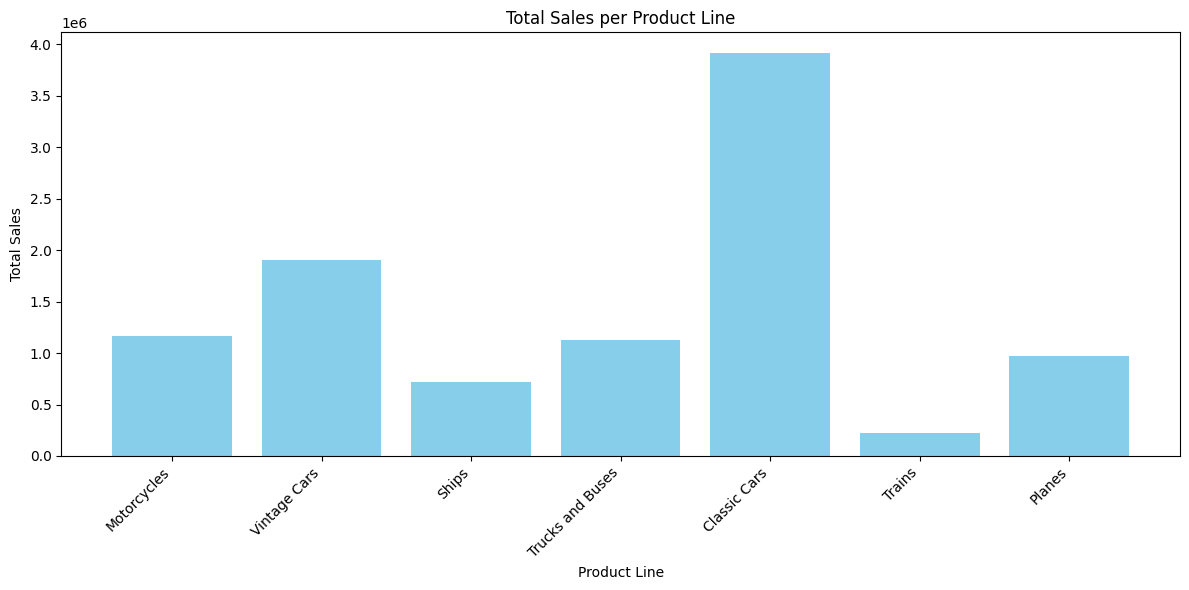

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the newly created table into a DataFrame
total_sales_df = spark.sql("SELECT * FROM `default`.`total_sales_per_product_line`")

# Convert the DataFrame to Pandas for plotting
total_sales_pandas = total_sales_df.toPandas()

# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(
    total_sales_pandas["PRODUCTLINE"], total_sales_pandas["TotalSales"], color="skyblue"
)
plt.xlabel("Product Line")
plt.ylabel("Total Sales")
plt.title("Total Sales per Product Line")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Plotting Sales by Shipment Status

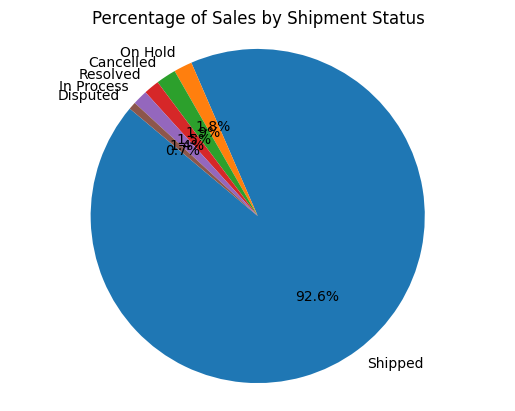

In [ ]:
# Load the data into a DataFrame
shipment_status_df = spark.sql(
    """
    SELECT * FROM `default`.`sales_by_shipment`
"""
)

# Convert to Pandas DataFrame for plotting
df = shipment_status_df.toPandas()
# Creating the pie chart
plt.pie(df["TotalSales"], labels=df["STATUS"], autopct="%1.1f%%", startangle=140)
plt.title("Percentage of Sales by Shipment Status")
plt.axis("equal")
plt.show()